<a href="https://colab.research.google.com/github/hlb-git/AI-ML-Tensorflow-Python/blob/main/Healthcare_Cost_Prediction_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-03-05 17:00:39--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.02s   

2025-03-05 17:00:39 (2.93 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
# check for blank cells

dataset.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
expenses,0


In [ ]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [ ]:
dataset = pd.concat([dataset, pd.get_dummies(dataset['sex'], prefix='sex')], axis=1)
dataset.drop('sex', inplace=True, axis=1)

dataset = pd.concat([dataset,pd.get_dummies(dataset['smoker'],prefix="smoker")],axis=1)
dataset.drop('smoker', axis=1, inplace=True)

dataset = pd.concat([dataset,pd.get_dummies(dataset['region'],prefix="region")],axis=1)
dataset.drop('region', axis=1, inplace=True)

dataset.head()

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,True,False,False,True,False,False,False,True
1,18,33.8,1,1725.55,False,True,True,False,False,False,True,False
2,28,33.0,3,4449.46,False,True,True,False,False,False,True,False
3,33,22.7,0,21984.47,False,True,True,False,False,True,False,False
4,32,28.9,0,3866.86,False,True,True,False,False,True,False,False


In [ ]:
dataset = dataset.astype(float)
dataset

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19.0,27.9,0.0,16884.92,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.8,1.0,1725.55,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.0,3.0,4449.46,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.7,0.0,21984.47,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.9,0.0,3866.86,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,31.0,3.0,10600.55,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,18.0,31.9,0.0,2205.98,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,18.0,36.9,0.0,1629.83,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,21.0,25.8,0.0,2007.95,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
data_columns = dataset.columns.drop('expenses')
input_data = dataset[data_columns].values
labels = dataset['expenses'].values

input_data.shape

(1338, 11)

In [ ]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(input_data, labels, train_size=0.8)

In [ ]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=input_data.shape[1]))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

model.compile(
    loss='mean_absolute_error',
    metrics=["mean_absolute_error", "mean_squared_error"],
    optimizer='adam')

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=10,
    mode='auto',
    restore_best_weights=True,
    verbose=True)

model.fit(
    train_dataset,
    train_labels,
    validation_data=(test_dataset, test_labels),
    callbacks=[early_stop], epochs=11111)

Epoch 1/11111


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 12953.5088 - mean_absolute_error: 12953.5088 - mean_squared_error: 312790048.0000 - val_loss: 13275.9941 - val_mean_absolute_error: 13275.9941 - val_mean_squared_error: 312738176.0000
Epoch 2/11111
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13364.6143 - mean_absolute_error: 13364.6143 - mean_squared_error: 334211584.0000 - val_loss: 13180.7227 - val_mean_absolute_error: 13180.7227 - val_mean_squared_error: 310074592.0000
Epoch 3/11111
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13006.6748 - mean_absolute_error: 13006.6748 - mean_squared_error: 312007680.0000 - val_loss: 12979.9199 - val_mean_absolute_error: 12979.9199 - val_mean_squared_error: 304527072.0000
Epoch 4/11111
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12175.5449 - mean_absolute_error: 12175.5449 - mean_squared_error: 281110112.0000 - val_loss: 12613.0996 - val_mean_absolute_error: 12613.0996 - val_mean_squared_error: 294610912.0000
Epoch 5/11111
34/34 ━━━━━━━━━━━━━

9/9 - 0s - 6ms/step - loss: 1944.6700 - mean_absolute_error: 1944.6700 - mean_squared_error: 23262362.0000
Testing set Mean Abs Error: 1944.67 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


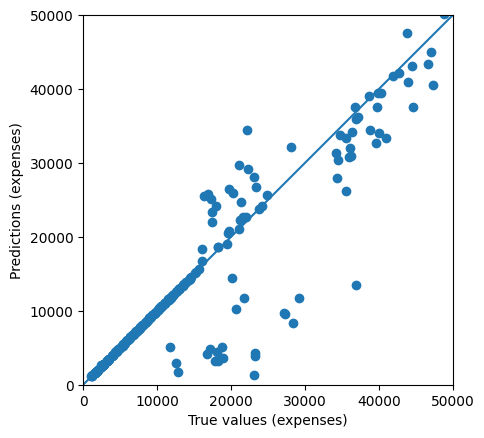

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
